In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime


pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

# Library

In [2]:
def counter_nan(series):
    '''Given a  vector it counts the number missing values '''
    return sum(series.isna())


def get_percentage_missing_data(df, threshold, show_percentage=False):
    '''Inputs: Datframe, thresold
    Function: return the features with more than thresold (%) of missing data'''
    rows=df.shape[0]
    missing_features = []
    perc_missing_features = {}
    for column in df.columns:
        counter_perc = counter_nan(df[column])/rows
        perc_missing_features[column] = round(counter_perc*100, 2)
        if counter_perc > threshold:
            missing_features.append(column)
        else:
            continue
            
    if show_percentage:
        print(perc_missing_features)
    else:
        pass
    return missing_features

def fill_nan_employment(df):
    '''# Fill nan employment status clients with indefined'''
    df['employment_status_clients'] = df['employment_status_clients'].replace(to_replace=np.nan, value='non-defined')
    return df
    


    
    
def birthday_to_age(string_date):
    '''Input: a date in a string format 
    Return: customer's age '''
    current_year = 2018
    #date format: yyyy-mm-dd hh:mm:ss 
    year_birthday = int(string_date.split('-')[0])
    age = 2018-year_birthday
    return age



def get_interest_data(previous_loan_df):
    '''Input: dataframe with the previous loans data
    Function: add two new columns to the dataframe containing the interest rate and the rate amount'''
    #total due is the amount of money customer has to pay to the bank after the loan is finished
    total_due = previous_loan_df['totaldue']
    #Loan amount is the amount of money the customer demanded to the bank
    loan_amount = previous_loan_df['loanamount']
    #interest is the amount of money the customer pay to have the loan 
    interest = total_due-loan_amount
    interest_rate = round((interest/loan_amount)*100,2)
    previous_loan_df['interest'] = interest
    previous_loan_df['interest_rate'] = interest_rate
    
    return previous_loan_df
    
    

def scale_termdays(previous_loan_df):
    '''Scale termdays using a year as unit'''
    previous_loan_df['termdays'] = round(previous_loan_df['termdays']/365, 2)
    return previous_loan_df
    
    
    
def get_date_features(df, keep_customer_id=False):
    '''Return a vector with the name of the date features'''
    
    if keep_customer_id:
        date_features = ['customerid']
    else:
        date_features = []
        
    for column in df.columns:
        if 'date' in column:
            date_features.append(column)
        else:
            continue
    return date_features



def get_non_date_features(df, keep_customer_id=False):
    '''Return a vector with the non date features'''
    if keep_customer_id:
        non_date_features = ['customerid']
    else:
        non_date_features = []
        
    for column in df.columns[1:]:
        if 'date' not in column:
            non_date_features.append(column)
        else:
            continue
    return non_date_features

    

def string_to_datetime(df):
    '''Convert date with string format into date variables'''
    for date_feature in get_date_features(df):
        df[date_feature] = df[date_feature].apply(lambda date: datetime.strptime(date.split(' ')[0], '%Y-%m-%d'))
    return df
    

    
def differentiate_dates(df, columns_to_differentiate=[]):
    '''Create a new column in which we store the distance between two dates'''
    #Days scale
    name_new_column = 'diff_'+columns_to_differentiate[0]+'_'+columns_to_differentiate[1]
    sec_in_day = 60*60*24
    #
    df[name_new_column] = df[columns_to_differentiate[0]] - df[columns_to_differentiate[1]]
    df[name_new_column] = df[name_new_column].apply(lambda x: round((x.total_seconds()/sec_in_day), 2))
    
    return df
    
    
def date_to_day(df):
    '''Create a new variable containing in which day of the week the due and the repaid took place'''
    columns_map = {
        'firstrepaiddate': 'repaid_dayofweek',
        'firstduedate': 'due_dayofweek'
    }
    for key, value in columns_map.items():
        df[value] = df[key].apply(lambda date: datetime.weekday(date))
    return df
        
        
        
def is_month_start(df):
    columns_map = {
        'firstrepaiddate': 'is_month_start_repaid',
        'firstduedate': 'is_month_start_due'
    }
    for key, value in columns_map.items():
        df[value] = df[key].apply(lambda date: 1 if date.day == 1 else 0)
    return df
    
    
            

def get_statistics_by_customer(df, stats=['max', 'min', 'mean']):
    '''Return a df with the aggregated data by customer
    
    '''
    df_dict = {}
    for stat in stats:
        if stat == 'max':
            rename_feature = {}
            for column in df.columns[2:]:
                rename_feature[column] = column+'_'+stat
            df_dict[stat] = df.groupby(['customerid']).max()
            df_dict[stat] = df_dict[stat].rename(columns=rename_feature)
            df_dict[stat] = df_dict[stat].drop(columns=['loannumber'])
        elif stat == 'min':
            rename_feature = {}
            for column in df.columns[2:]:
                rename_feature[column] = column+'_'+stat
            df_dict[stat] = df.groupby(['customerid']).min()
            df_dict[stat] = df_dict[stat].rename(columns=rename_feature)
            df_dict[stat] = df_dict[stat].drop(columns=['loannumber'])
        elif stat == 'mean':
            rename_feature = {}
            for column in df.columns[2:]:
                rename_feature[column] = column+'_'+stat
            df_dict[stat] = df.groupby(['customerid']).mean()
            df_dict[stat] = df_dict[stat].rename(columns=rename_feature)
            df_dict[stat] = df_dict[stat].drop(columns=['loannumber'])
            
    df_stat = df_dict[stats[0]]
            
    if len(stats) == 2:
        df_stat = pd.concat([df_dict[stats[0]], df_dict[stats[1]]], axis=1)
    elif len(stats) == 3:
        df_stat = pd.concat([df_dict[stats[0]], df_dict[stats[1]], df_dict[stats[2]]], axis=1)
    else:
        pass
        
    
    return df_stat

In [3]:
train_perf

NameError: name 'train_perf' is not defined

-----

# Loading Data

**Demogrpahic data set processing**
- Check for missing values
- Drop 3 columns with missing values greater than 90%
- Get ageo of cutomer from birth date

In [4]:
def transform_demographic(demographics):
    #Drop the features with 80% or greater of missing data
    columns_to_drop = get_percentage_missing_data(demographics, 0.8, show_percentage=False)
    demographics = demographics.drop(columns=columns_to_drop)
    #Nan == employment non defined
    demographics = fill_nan_employment(demographics)
    demographics['birthdate'] = demographics['birthdate'].apply(birthday_to_age)
    rename_mapping = {'birthdate': 'age'}
    demographics = demographics.rename(columns=rename_mapping)
    
    return demographics

In [5]:
def transform_perf(performance):
    performance = get_interest_data(performance)
    #performance = scale_termdays(performance)
    performance = performance.drop(columns=['approveddate', 'creationdate', 'referredby', 'systemloanid'])
    return performance
    

In [6]:
def transform_prevloans(prevloans, aggregate_stats=['mean']):
    #Transform prevloans
    #payment info
    prevloans = get_interest_data(prevloans)
    prevloans = scale_termdays(prevloans)
    #date features treatment
    date_features_df = prevloans.drop(columns=get_non_date_features(prevloans))
    #String dates to datetime format
    date_features_df = string_to_datetime(date_features_df)
    #Create a two features tha computes the 'speed' of repayment
    date_features_df = differentiate_dates(date_features_df, ['firstrepaiddate','firstduedate'])
    date_features_df = differentiate_dates(date_features_df, ['closeddate', 'creationdate'])
    #Which day of the week the due and the repaid took place
    date_features_df = date_to_day(date_features_df)
    #Merge the transformed date features with the prevloans data
    prevloans = pd.concat([prevloans,date_features_df.drop(columns=get_date_features(prevloans, keep_customer_id=True))], axis=1)
    #Non relevant variables once transformed the data
    columns_to_drop = ['systemloanid', 'approveddate', 'creationdate', 'closeddate', 'referredby', 'firstduedate',
                  'firstrepaiddate']
    prevloans = prevloans.drop(columns=columns_to_drop)
    #final prev loans data
    prevloans = get_statistics_by_customer(prevloans, stats=aggregate_stats)
    prevloans['customerid'] = prevloans.index
    prevloans = prevloans.reset_index(drop=True)
    
    return prevloans

def merge_data(demographics, prevloans, perf):
    final_data = perf.merge(demographics, on=['customerid'], how='inner').merge(prevloans, on=['customerid'], how='inner')
    final_data['good_bad_flag'] = final_data['good_bad_flag'].apply(lambda x: 1 if x=='Good' else 0)
    return final_data 

def one_hot_encoding(df):
    onehot_encoding = []
    for column in final_data.columns:
        if isinstance(final_data[column][0], str) and (column != 'good_bad_flag') and (column != 'customerid'):
            onehot_encoding.append(column)
        else:
            pass
    df = pd.get_dummies(df, columns=onehot_encoding)
    
    return df


    
    

In [7]:
train_perf = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/trainperf.csv', low_memory=False)
train_prevloans = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/trainprevloans.csv', low_memory=False)
train_demographics = pd.read_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/traindemographics.csv', low_memory=False)



In [8]:
demographics = transform_demographic(train_demographics)

In [9]:
#Select the statistic function to compute to aggregate the prev loans
prevloans = transform_prevloans(train_prevloans, aggregate_stats=['mean'])

In [10]:
perf = transform_perf(train_perf)

In [16]:
final_data = merge_data(demographics, prevloans, perf)

In [17]:
final_data = one_hot_encoding(final_data)

In [20]:
final_data.to_csv('/Users/ayoubelqadi/PycharmProjects/zindi_paper/data/merged_data.csv', index=False)

In [291]:
final_data = one_hot_encoding(final_data)
X = final_data.drop(columns=['customerid', 'good_bad_flag'])#.to_numpy()
y = final_data['good_bad_flag']#.to_numpy(dtype=np.int)


In [19]:
final_data

,customerid,loannumber,loanamount,totaldue,termdays,good_bad_flag,interest,interest_rate,age,longitude_gps,latitude_gps,loanamount_mean,totaldue_mean,termdays_mean,interest_mean,interest_rate_mean,diff_firstrepaiddate_firstduedate_mean,diff_closeddate_creationdate_mean,repaid_dayofweek_mean,due_dayofweek_mean,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,bank_name_clients_Access Bank,bank_name_clients_Diamond Bank,bank_name_clients_EcoBank,bank_name_clients_FCMB,bank_name_clients_Fidelity Bank,bank_name_clients_First Bank,bank_name_clients_GT Bank,bank_name_clients_Heritage Bank,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,employment_status_clients_non-defined
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,34500.0,30,1,4500.0,15.00,46,3.432010,6.433055,18181.818182,22081.818182,0.080000,3900.000000,22.909091,-0.909091,30.000000,2.000000,1.636364,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,8a8588f35438fe12015444567666018e,7,20000.0,22250.0,15,1,2250.0,11.25,34,11.139350,10.292041,10000.000000,11750.000000,0.046667,1750.000000,17.500000,0.833333,18.833333,2.166667,1.333333,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,8a85890754145ace015429211b513e16,3,10000.0,11500.0,15,1,1500.0,15.00,41,3.985770,7.491708,10000.000000,12250.000000,0.060000,2250.000000,22.500000,7.500000,31.500000,4.000000,0.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,8a858970548359cc0154883481981866,9,40000.0,44000.0,30,1,4000.0,10.00,32,7.457913,9.076574,18750.000000,23550.000000,0.100000,4800.000000,25.875000,-3.125000,27.375000,3.375000,1.250000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,8a858e095c59b91b015c5e5cea3719bc,3,10000.0,13000.0,30,1,3000.0,30.00,29,3.259444,6.557011,10000.000000,12250.000000,0.060000,2250.000000,22.500000,-2.500000,20.000000,0.500000,3.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858e395cb1d4d9015cb2115b1d13d7,2,10000.0,11500.0,15,0,1500.0,15.00,39,3.302387,6.568690,10000.000000,11500.000000,0.040000,1500.000000,15.000000,0.000000,17.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3268,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.0,13000.0,30,0,3000.0,30.00,29,4.607358,8.460608,10000.000000,13000.000000,0.080000,3000.000000,30.000000,-4.000000,27.000000,3.000000,0.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3269,8a858f365b2547f3015b284597147c94,3,10000.0,11500.0,15,0,1500.0,15.00,29,3.976842,7.409129,10000.000000,11500.000000,0.040000,1500.000000,15.000000,8.000000,23.500000,3.000000,2.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3270,8a858f935ca09667015ca0ee3bc63f51,2,10000.0,13000.0,30,0,3000.0,30.00,28,3.986089,7.386796,10000.000000,13000.000000,0.080000,3000.000000,30.000000,0.000000,30.000000,3.000000,3.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [292]:
sum(y==1)/len(y)

0.78239608801956

In [293]:
X

,loannumber,loanamount,totaldue,termdays,interest,interest_rate,age,longitude_gps,latitude_gps,loanamount_mean,totaldue_mean,termdays_mean,interest_mean,interest_rate_mean,diff_firstrepaiddate_firstduedate_mean,diff_closeddate_creationdate_mean,repaid_dayofweek_mean,due_dayofweek_mean,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,bank_name_clients_Access Bank,bank_name_clients_Diamond Bank,bank_name_clients_EcoBank,bank_name_clients_FCMB,bank_name_clients_Fidelity Bank,bank_name_clients_First Bank,bank_name_clients_GT Bank,bank_name_clients_Heritage Bank,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,employment_status_clients_non-defined
0,12,30000.0,34500.0,30,4500.0,15.00,46,3.432010,6.433055,18181.818182,22081.818182,0.080000,3900.000000,22.909091,-0.909091,30.000000,2.000000,1.636364,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,7,20000.0,22250.0,15,2250.0,11.25,34,11.139350,10.292041,10000.000000,11750.000000,0.046667,1750.000000,17.500000,0.833333,18.833333,2.166667,1.333333,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,10000.0,11500.0,15,1500.0,15.00,41,3.985770,7.491708,10000.000000,12250.000000,0.060000,2250.000000,22.500000,7.500000,31.500000,4.000000,0.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,40000.0,44000.0,30,4000.0,10.00,32,7.457913,9.076574,18750.000000,23550.000000,0.100000,4800.000000,25.875000,-3.125000,27.375000,3.375000,1.250000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3,10000.0,13000.0,30,3000.0,30.00,29,3.259444,6.557011,10000.000000,12250.000000,0.060000,2250.000000,22.500000,-2.500000,20.000000,0.500000,3.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,2,10000.0,11500.0,15,1500.0,15.00,39,3.302387,6.568690,10000.000000,11500.000000,0.040000,1500.000000,15.000000,0.000000,17.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3268,2,10000.0,13000.0,30,3000.0,30.00,29,4.607358,8.460608,10000.000000,13000.000000,0.080000,3000.000000,30.000000,-4.000000,27.000000,3.000000,0.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3269,3,10000.0,11500.0,15,1500.0,15.00,29,3.976842,7.409129,10000.000000,11500.000000,0.040000,1500.000000,15.000000,8.000000,23.500000,3.000000,2.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3270,2,10000.0,13000.0,30,3000.0,30.00,28,3.986089,7.386796,10000.000000,13000.000000,0.080000,3000.000000,30.000000,0.000000,30.000000,3.000000,3.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


------
# Model Development

In [294]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [295]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_true = final_data['good_bad_flag'].to_numpy(dtype=np.int)

In [296]:
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns)

In [262]:
#Optimized data structure for xgboost
data_matrix = xgb.DMatrix(data=X, label=y)
#Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, random_state=435, test_size=0.25)

In [263]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
#Function to compute the main classification metrics
def classification_metrics(model):
    y_hat = model.predict(X_test)
    f1 = f1_score(y_true=y_test, y_pred=y_hat)
    f1 = round(f1*100, 4)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
    accuracy = round(accuracy*100, 4)
    precision = precision_score(y_true=y_test, y_pred=y_hat)
    precision = round(precision*100, 4)
    recall = recall_score(y_true=y_test, y_pred=y_hat)
    recall = round(recall*100, 4)
    print('Accuracy = {}\nF1 = {}\nPrecision = {}\nRecall = {}\n'.format(accuracy, f1, precision, recall))
    conf_matrix = confusion_matrix(y_pred=y_hat, y_true=y_test)
    return conf_matrix
    
    

In [297]:
paper_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'reg_alpha': 1,
    'max_depth': 6,
    'objective': 'binary:logistic'
}

paper_model = xgb.XGBClassifier(**paper_params, use_label_encoder=False )
paper_model.fit(X_scaled, y_true)
classification_metrics(paper_model)

[18:16:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 90.0978
F1 = 93.9417
Precision = 89.4587
Recall = 98.8976



array([[109,  74],
       [  7, 628]])

In [265]:
paper_model.predict_proba(X_test)

array([[0.15629297, 0.843707  ],
       [0.32207316, 0.67792684],
       [0.03270108, 0.9672989 ],
       ...,
       [0.12941104, 0.87058896],
       [0.1546945 , 0.8453055 ],
       [0.10729223, 0.89270777]], dtype=float32)

# Hyperparameter tuning

In [78]:
params_grid = {
    'n_estimators': [900, 1000],
    'learning_rate': [ 0.2, 0.3],
    'max_depth': [6, 8, 12],
    #'min_child_weight': np.arange(1, 9, 2),
    'gamma': [0.3],
    #'colsample_bytree': np.arange(0.3, 0.9, 0.2),
    'subsample': [0.8]
}

xgb_m = xgb.XGBClassifier(objective='binary:logistic', eval_metric=['auc'], use_label_encoder=False)
grid_search = GridSearchCV(xgb_m, param_grid=params_grid, cv=5, verbose=2, scoring='recall', n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

In [20]:
best_model = xgb.XGBClassifier(**grid_search.best_params_,objective='binary:logistic', eval_metric=['auc'], use_label_encoder=False)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric=['auc'],
              gamma=0.3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=12,
              num_parallel_tree=1, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [21]:
classification_metrics(best_model)

Accuracy = 73.3496
F1 = 83.4347
Precision = 80.6167
Recall = 86.4567



array([[ 51, 132],
       [ 86, 549]])

In [18]:
from sklearn.metrics import roc_auc_score, auc, roc_curve
def results_model_test(model_name):
    
    prob = model_name.predict_proba(X_test)
    pred = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [19]:
results_model_test(best_model)

NameError: name 'best_model' is not defined

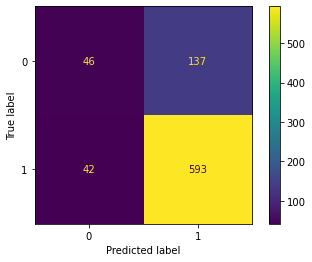

In [184]:
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix


plot_confusion_matrix(best_model, X_test, y_test)

## Randomized Search


In [42]:
from sklearn.model_selection import RandomizedSearchCV

rand_params = {
    'n_estimators':[500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'min_split_loss': [0, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 13, 1),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'reg_lambda': [0, 0.5, 1, 2],
    'reg_alpha': [0, 0.5, 1, 2]    
}

xgb_rd = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric=['auc'])
random_search = RandomizedSearchCV(xgb_rd, n_iter=100, param_distributions=rand_params, cv=5, return_train_score=True, verbose=10, scoring='roc_auc', n_jobs=-1 )

random_search.fit(X_train, y_train)
best_rd = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric=['auc'], **random_search.best_params_).fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

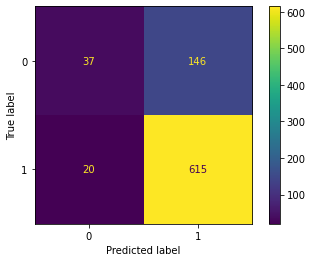

In [43]:
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
plot_confusion_matrix(best_rd, X_test, y_test)

In [44]:
random_search.best_params_

{'subsample': 1,
 'reg_lambda': 0,
 'reg_alpha': 1,
 'n_estimators': 500,
 'min_split_loss': 0.1,
 'max_depth': 5,
 'learning_rate': 0.01}

In [47]:
classification_metrics(best_rd)

Accuracy = 79.7066
F1 = 88.1089
Precision = 80.8147
Recall = 96.8504



array([[ 37, 146],
       [ 20, 615]])

____

In [298]:
import shap
shap.initjs()

In [299]:
#Fix problems with shap
mybooster = paper_model.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun


In [300]:
explainer = shap.TreeExplainer(paper_model)   # define the explainer
shap_values = explainer.shap_values(X_scaled_df)  # use all data for analysis

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


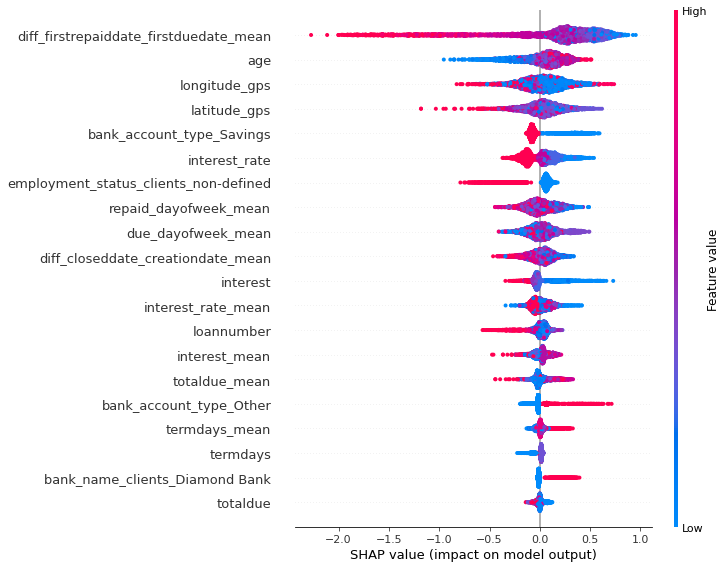

In [301]:
plot = shap.summary_plot(shap_values, X_scaled_df)

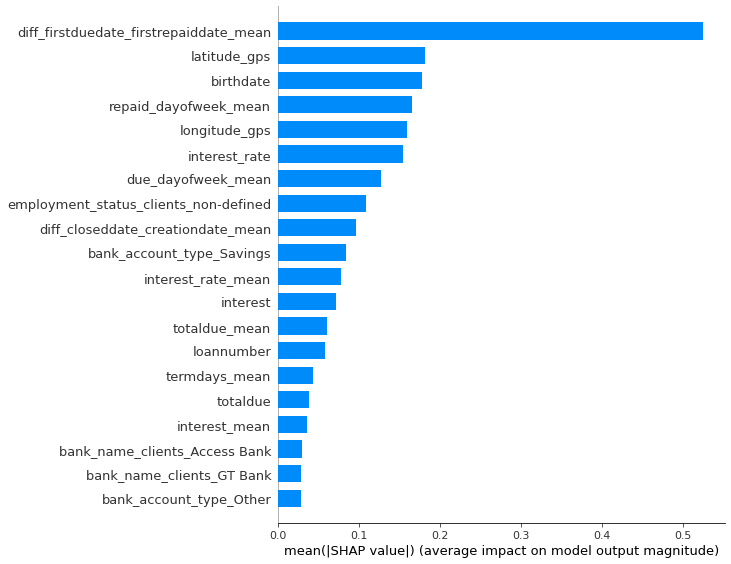

In [170]:
shap.summary_plot(shap_values, X, plot_type="bar")

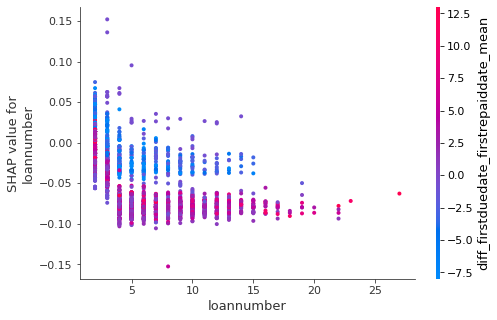

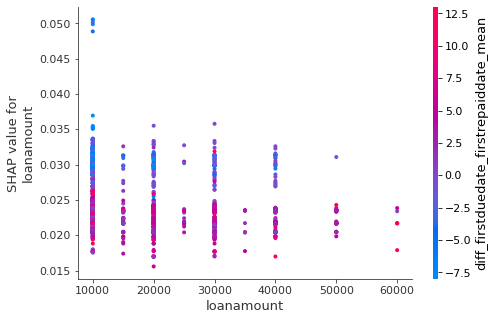

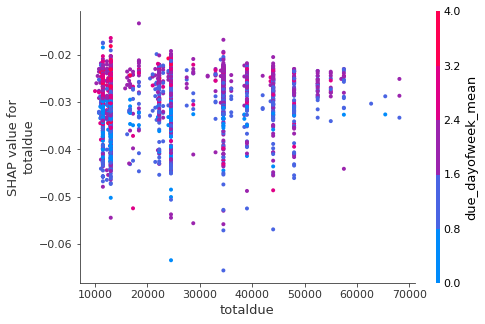

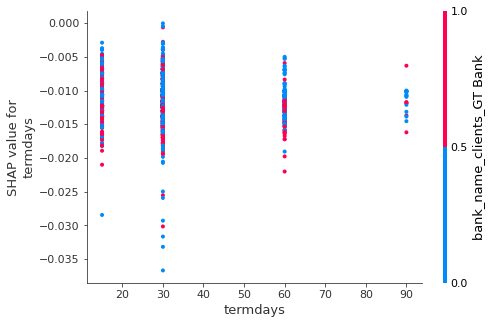

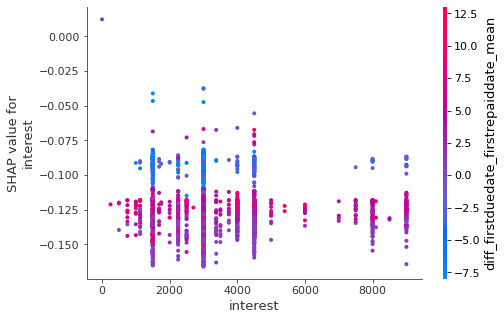

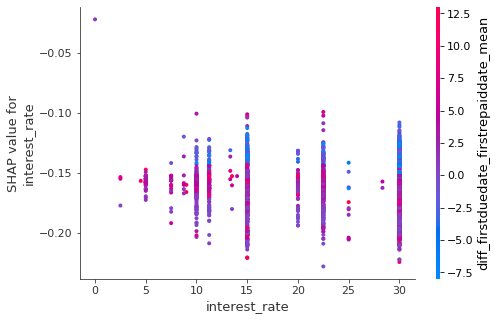

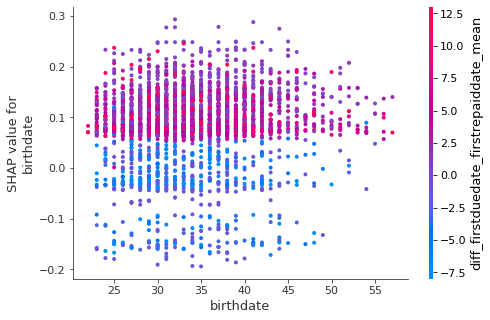

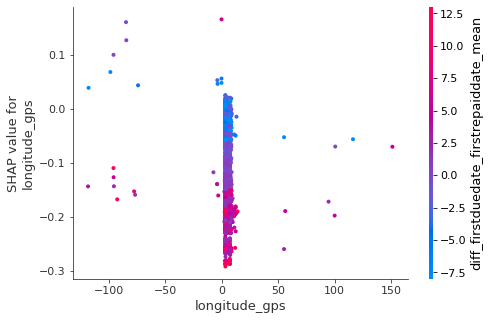

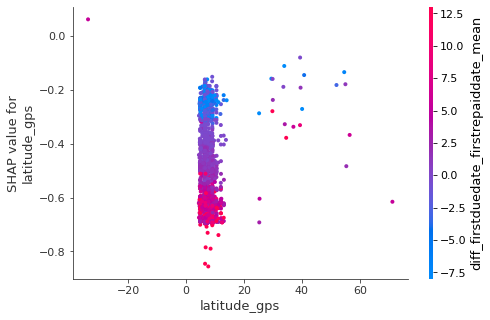

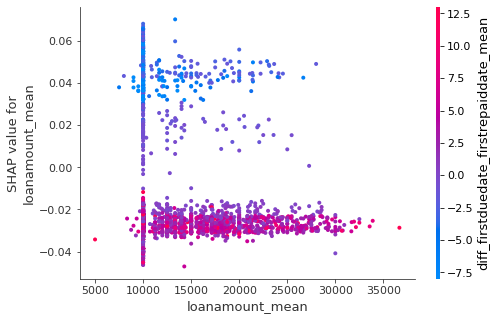

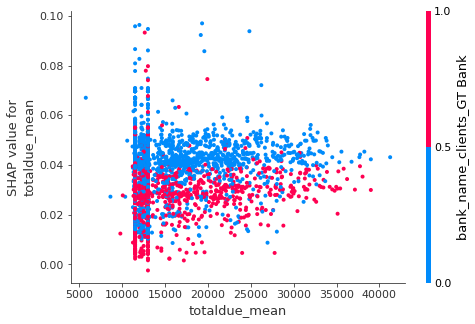

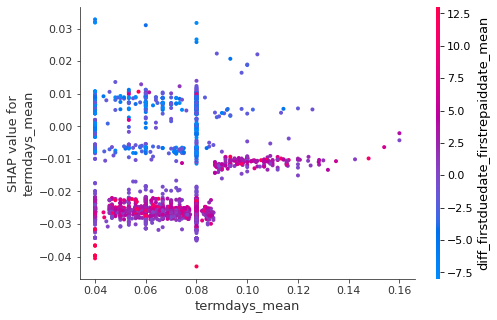

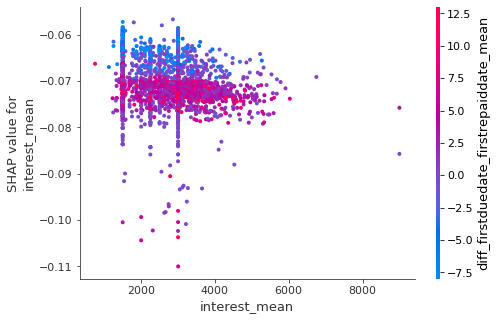

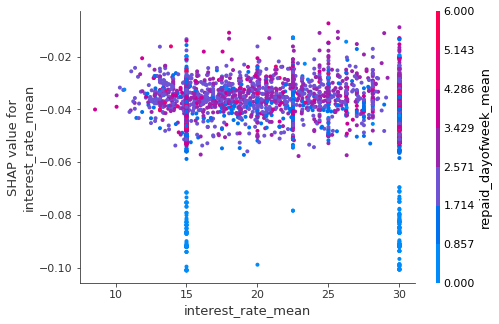

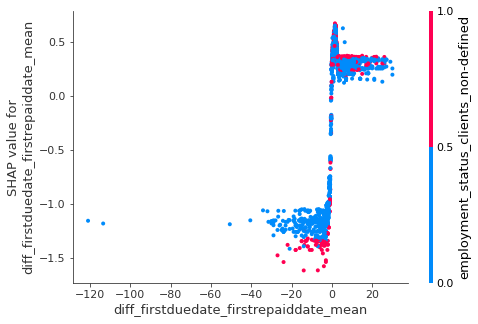

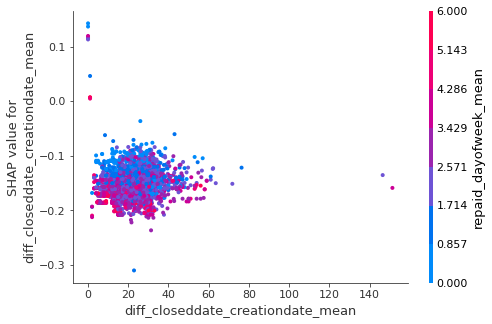

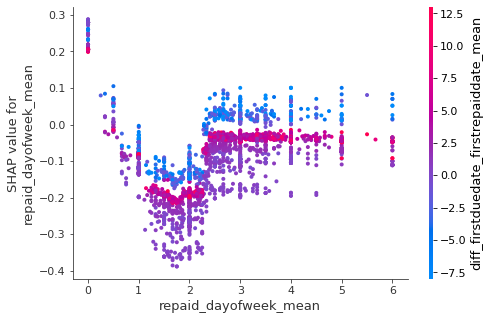

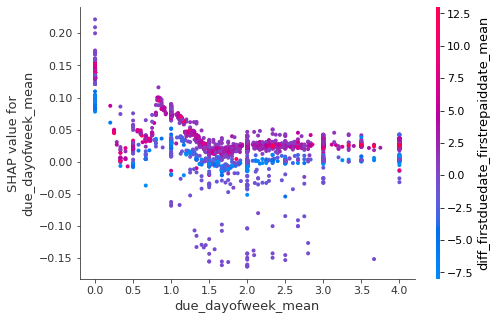

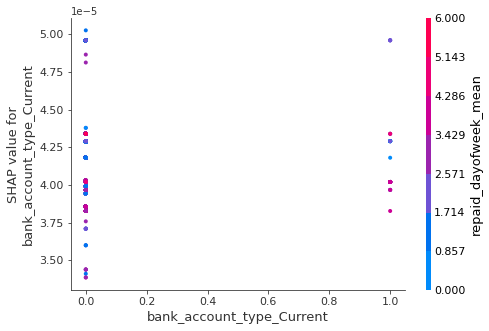

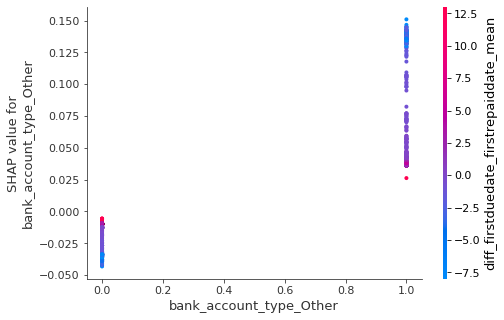

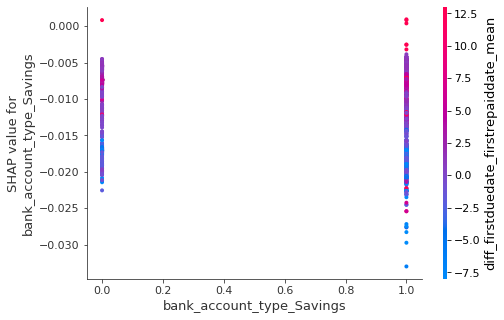

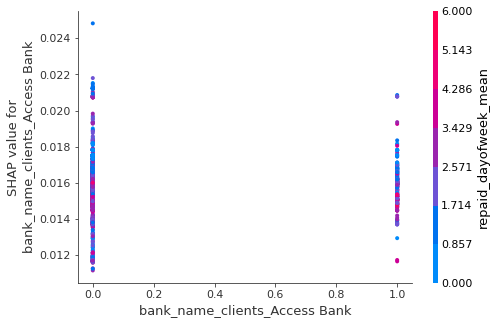

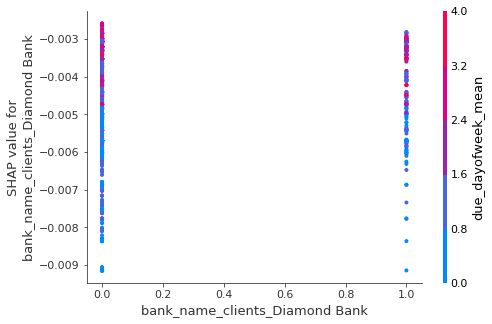

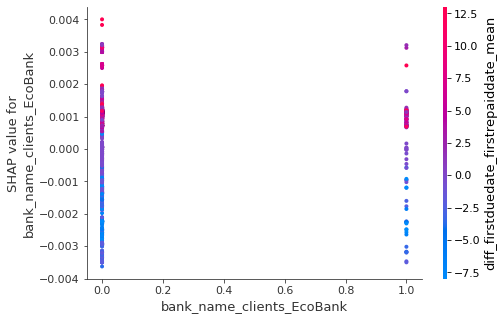

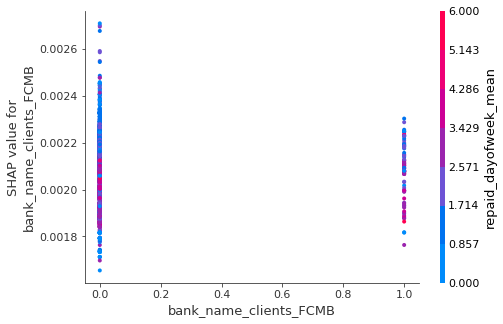

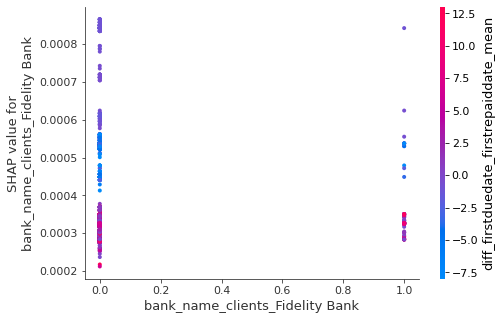

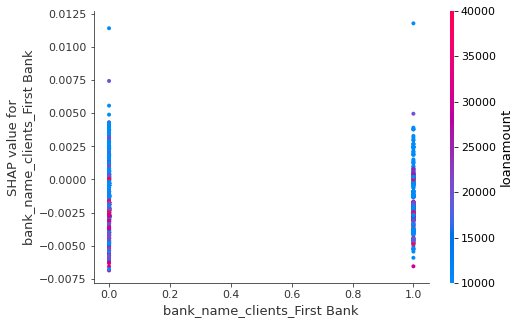

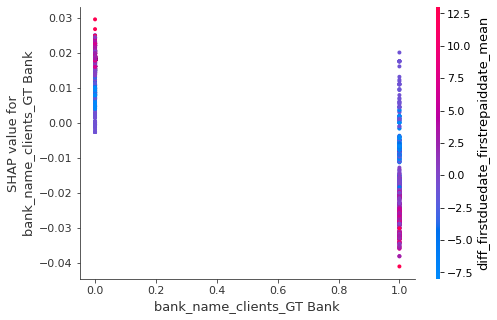

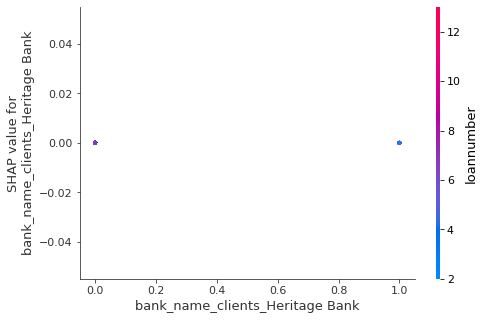

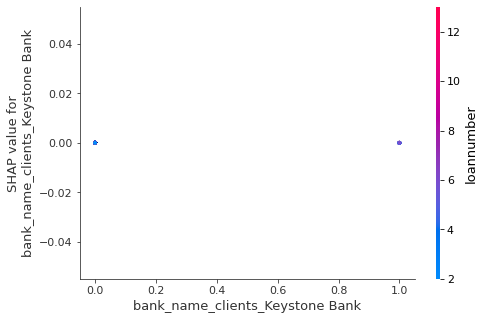

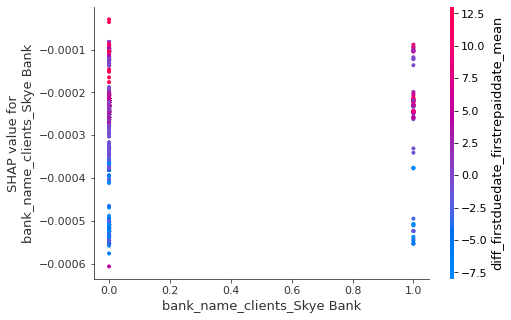

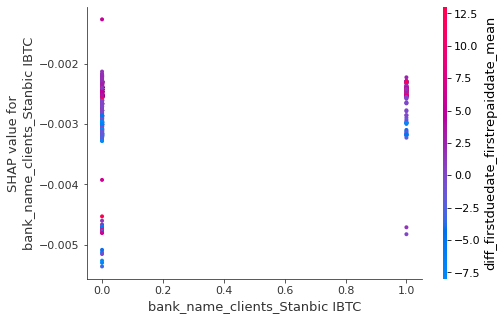

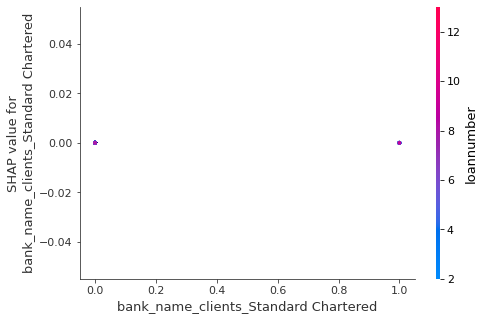

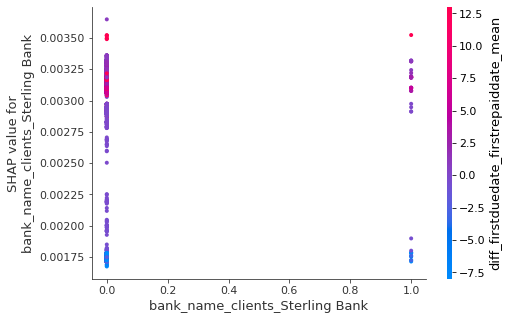

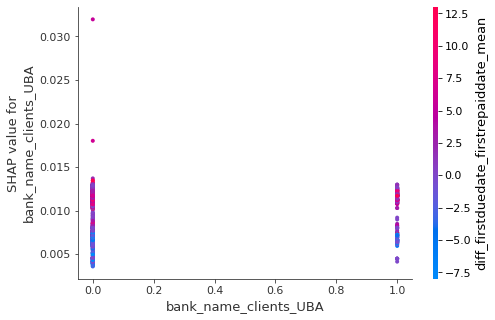

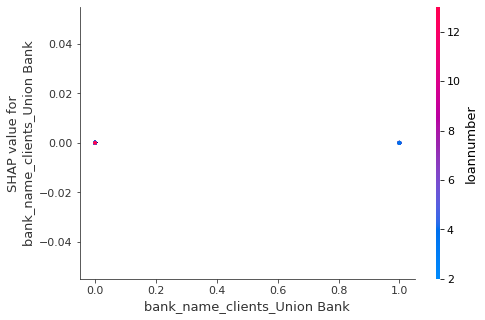

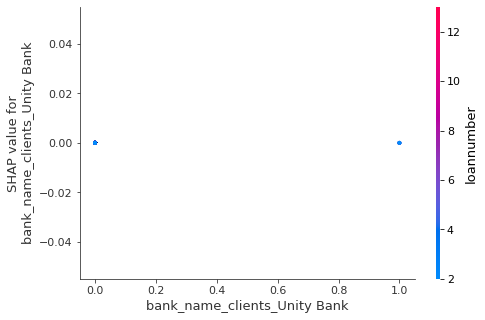

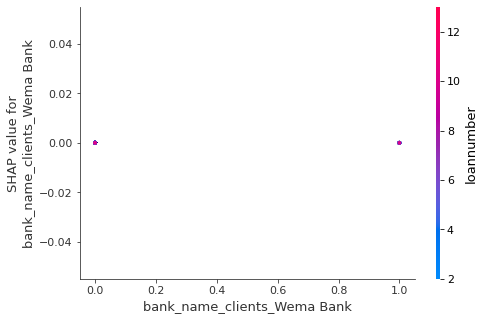

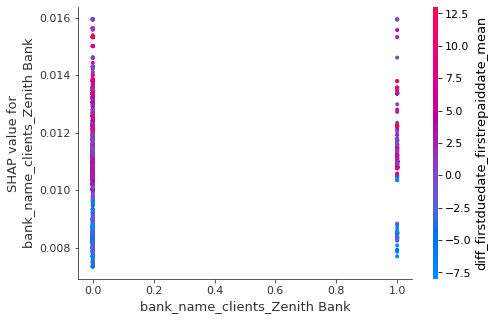

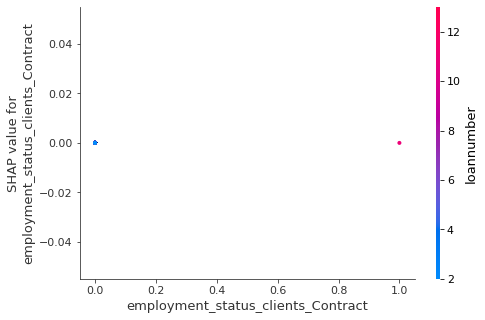

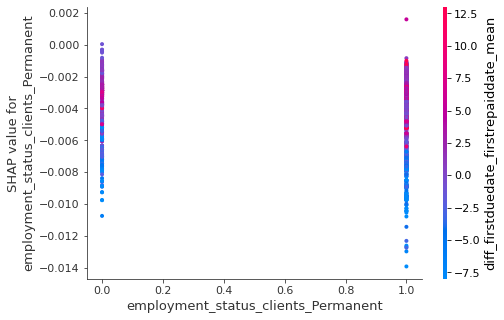

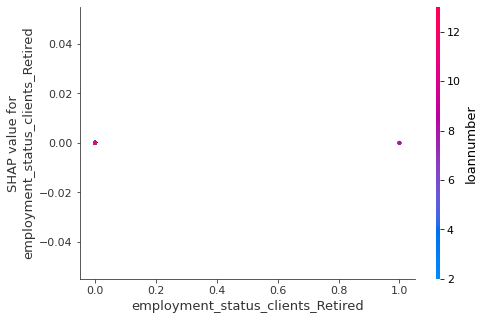

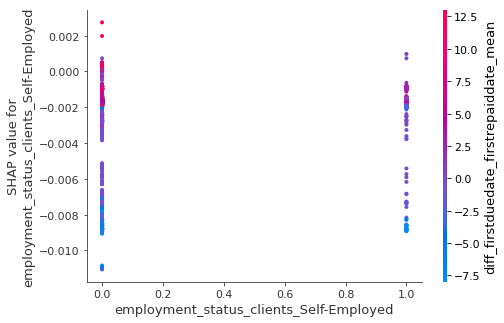

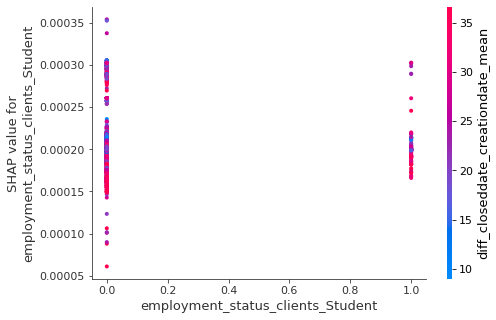

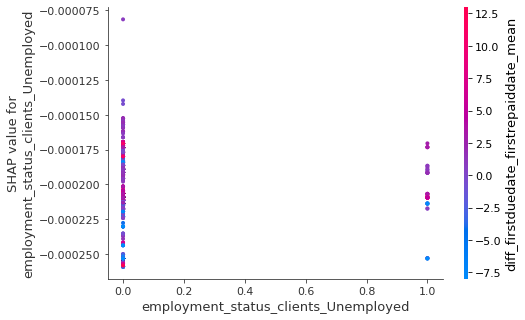

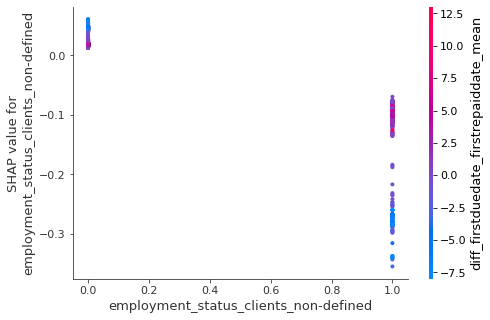

In [86]:

for name in X.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)

In [89]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [96]:
X,y = shap.datasets.boston()

In [97]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [100]:

import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

#Fix problems with shap
mybooster = bst.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun



# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explaination with default colors
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

AttributeError: 'Booster' object has no attribute 'get_booster'